# Simulate second-order systems

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from odefilter import ivpsolve, recipes

config.update("jax_enable_x64", True)
backend.select("jax")

Quick refresher: first-order ODEs

In [2]:
f, u0, (t0, t1), f_args = ivps.three_body_restricted_first_order()


@jax.jit
def vf_1(y, t, p):
    return f(y, *p)


ek0_1 = recipes.ekf0_isotropic(num_derivatives=5)
ts = jnp.linspace(t0, t1, endpoint=True, num=500)

In [3]:
%%time

solution = ivpsolve.simulate_checkpoints(
    vf_1,
    initial_values=(u0,),
    ts=ts,
    solver=ek0_1,
    atol=1e-5,
    rtol=1e-5,
    parameters=f_args,
)

CPU times: user 10.1 s, sys: 124 ms, total: 10.2 s
Wall time: 9.59 s


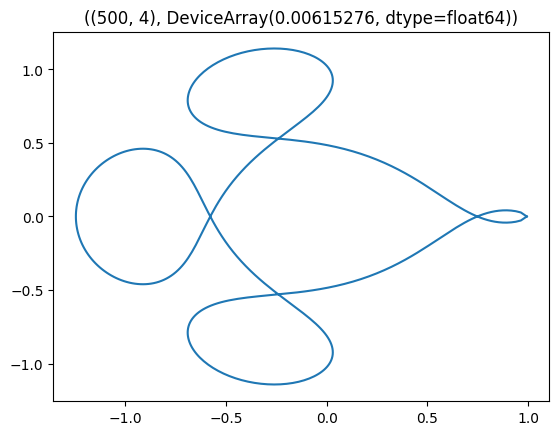

In [4]:
plt.title((solution.u.shape, jnp.linalg.norm(solution.u[-1, ...] - u0)))
plt.plot(solution.u[:, 0], solution.u[:, 1])
plt.show()

In [5]:
f, (u0, du0), (t0, t1), f_args = ivps.three_body_restricted()


@jax.jit
def vf_2(y, dy, t, p):
    return f(y, dy, *p)


# One derivative more than above because we don't transform to first order
ek0_2 = recipes.ekf0_isotropic(num_derivatives=6, ode_order=2)
ts = jnp.linspace(t0, t1, endpoint=True, num=500)

In [6]:
%%time

solution = ivpsolve.simulate_checkpoints(
    vf_2,
    initial_values=(u0, du0),
    ts=ts,
    solver=ek0_2,
    atol=1e-5,
    rtol=1e-5,
    parameters=f_args,
)

CPU times: user 8.97 s, sys: 41.5 ms, total: 9.01 s
Wall time: 8.38 s


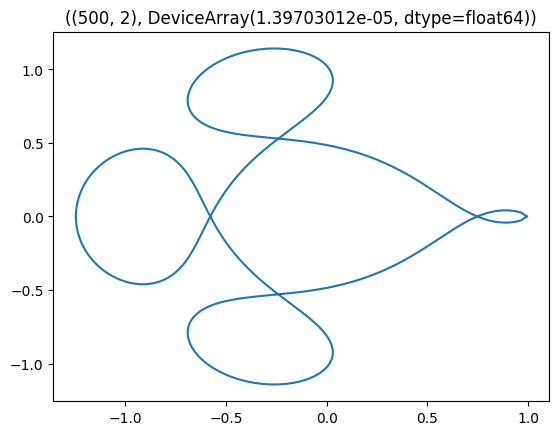

In [7]:
plt.title((solution.u.shape, jnp.linalg.norm(solution.u[-1, ...] - u0)))
plt.plot(solution.u[:, 0], solution.u[:, 1])
plt.show()

The second-order solver is faster and way more accurate.